In [1]:
from os import path
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd

import numpy as np

from datetime import datetime, timezone
from dateutil import tz
import pytz

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

In [68]:
df = pd.read_csv("wattime_data.csv")
df["date"] = pd.to_datetime(df.point_time)
df["date_PT"] = pd.DatetimeIndex(df['date']).tz_convert("America/Los_Angeles")
df = df.drop(columns="date")
df["time"] = pd.DatetimeIndex(df['date_PT']).time
df["year"] = [d.year for d in df["date_PT"]]
df["month"] = [d.month for d in df["date_PT"]]
df["day_of_month"] = pd.DatetimeIndex(df['date_PT']).day
df["day_of_week"] = [datetime.weekday(d) for d in df["date_PT"]]
df["day_of_week"] = df["day_of_week"].replace({0 : "Mon", 1 : "Tue", 2 : "Wed", 3 : "Thu", 4 : "Fri", 5 : "Sat", 6 : "Sun"})
df["hour"] = [d.hour for d in df["time"]]
df["minute"] = [d.hour * 60 + d.minute for d in df["time"]]
df = df.drop("Unnamed: 0", axis=1)
df = df.drop("point_time", axis=1)
df = df.rename(columns = {"value" : "MOER"})
# 30 minute rolling average of MOER
df["MOER_rolling"] = df['MOER'].rolling(6).mean()
df = df.iloc[5: , :]
df = df.reset_index()
df

,index,MOER,frequency,market,ba,datatype,version,date_PT,time,year,month,day_of_month,day_of_week,hour,minute,MOER_rolling
0,5,1021.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 16:25:00-08:00,16:25:00,2017,12,31,Sun,16,985,1021.333333
1,6,1018.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 16:30:00-08:00,16:30:00,2017,12,31,Sun,16,990,1020.666667
2,7,1013.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 16:35:00-08:00,16:35:00,2017,12,31,Sun,16,995,1019.166667
3,8,1018.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 16:40:00-08:00,16:40:00,2017,12,31,Sun,16,1000,1018.666667
4,9,1006.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 16:45:00-08:00,16:45:00,2017,12,31,Sun,16,1005,1016.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499182,499187,920.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 19:10:00-07:00,19:10:00,2022,9,29,Thu,19,1150,918.000000
499183,499188,918.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 19:15:00-07:00,19:15:00,2022,9,29,Thu,19,1155,918.500000
499184,499189,918.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 19:20:00-07:00,19:20:00,2022,9,29,Thu,19,1160,919.000000
499185,499190,917.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 19:25:00-07:00,19:25:00,2022,9,29,Thu,19,1165,919.333333


## Looking at the distribution of MOER Values

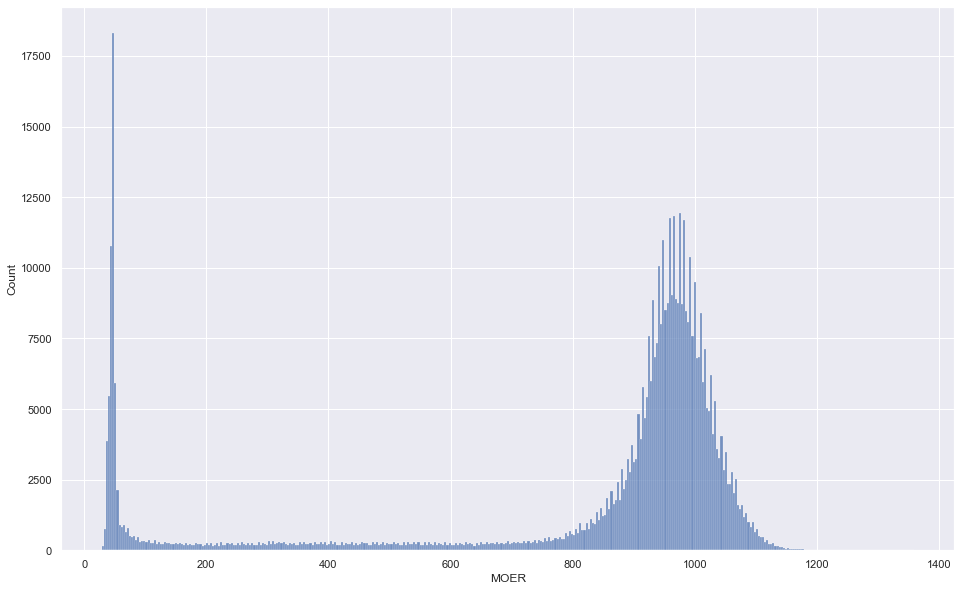

In [4]:
sns.set(rc={'figure.figsize':(16, 10)});
sns.histplot(data=df, x="MOER");

## Looking at MOERs by Day of Week
- Noticable drop during the weekends. 
- Monday and Friday are the lowest weekdays, which also makes sense (3-day weekends)

In [5]:
by_dow = df[["day_of_week", "MOER"]].groupby("day_of_week").mean()
by_dow = by_dow.reindex(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
by_dow

,MOER
day_of_week,
Mon,827.732295
Tue,835.494358
Wed,834.459318
Thu,834.194287
Fri,826.213971
Sat,780.411397
Sun,765.392963


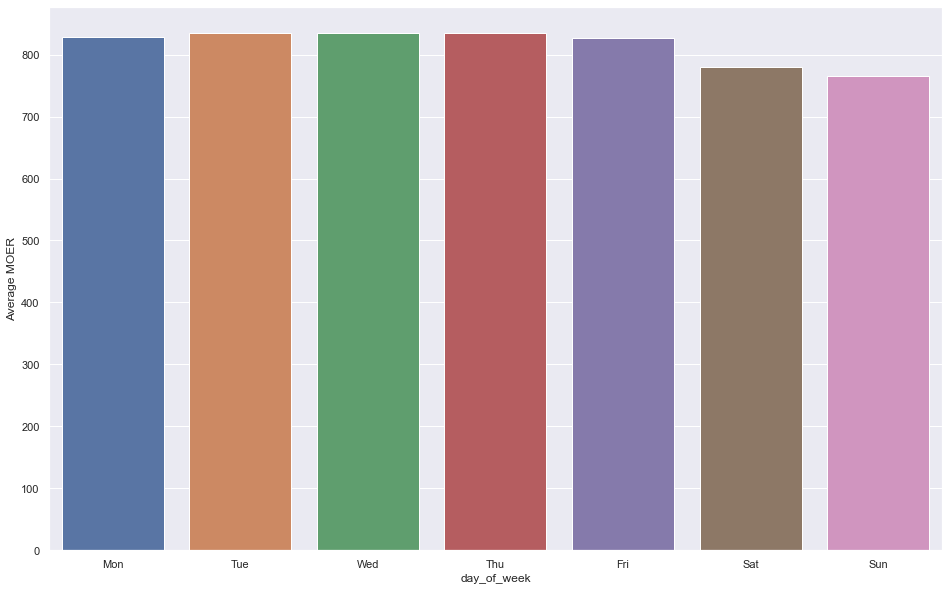

In [6]:
sns.barplot(data=by_dow, x=by_dow.index, y="MOER")
plt.ylabel("Average MOER");

## Looking at most polluting hours of the week.
* Looking at waking hours 8am - midnight

In [204]:
df_hourly = df[(df["minute"] % 60 == 0) & (~df["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7]))]
#df_hourly = df[(df["minute"] % 60 == 0)]
df_hourly

,index,MOER,frequency,market,ba,datatype,version,date_PT,time,year,month,day_of_month,day_of_week,hour,minute,MOER_rolling
7,12,1007.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 17:00:00-08:00,17:00:00,2017,12,31,Sun,17,1020,1012.833333
19,24,1039.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 18:00:00-08:00,18:00:00,2017,12,31,Sun,18,1080,1004.333333
31,36,1021.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 19:00:00-08:00,19:00:00,2017,12,31,Sun,19,1140,1035.833333
43,48,966.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 20:00:00-08:00,20:00:00,2017,12,31,Sun,20,1200,988.333333
55,60,1032.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 21:00:00-08:00,21:00:00,2017,12,31,Sun,21,1260,983.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499132,499137,943.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 15:00:00-07:00,15:00:00,2022,9,29,Thu,15,900,948.333333
499144,499149,986.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 16:00:00-07:00,16:00:00,2022,9,29,Thu,16,960,1008.333333
499156,499161,997.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 17:00:00-07:00,17:00:00,2022,9,29,Thu,17,1020,999.666667
499168,499173,900.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 18:00:00-07:00,18:00:00,2022,9,29,Thu,18,1080,899.833333


In [205]:
by_hour_of_week = df_hourly.groupby(["day_of_week", "hour"])[["MOER"]].mean()
by_hour_of_week.sort_values("MOER").head(20)

MOER
day_of_week hour            
Sun         11    422.234818
            10    424.174089
            9     434.550607
            12    441.983806
            13    442.781377
Sat         11    459.473684
            12    464.931174
            13    471.105263
Sun         14    475.141700
Sat         10    481.493927
            9     483.995951
            14    507.882591
            15    536.064777
Sun         15    536.789474
            8     560.566802
Mon         13    575.983871
Fri         12    576.821862
Mon         10    595.370968
Fri         13    596.315789
Sat         8     597.923077

In [206]:
by_hour_of_week.sort_values("MOER", ascending=True).sort_values("MOER", ascending=False).head(20)

MOER
day_of_week hour            
Tue         21    971.495968
Mon         20    971.028226
Wed         20    970.354839
Tue         20    969.459677
Mon         21    969.173387
Thu         20    968.651822
            21    968.303644
Wed         21    968.225806
Sun         20    967.830645
Fri         21    966.975709
Thu         22    966.384615
Mon         22    966.108871
Sun         21    964.955645
Tue         22    964.923387
Fri         20    964.161943
            22    963.676113
Wed         19    962.975806
Tue         23    962.806452
Wed         22    962.705645
Tue         19    961.858871

In [207]:
def get_percentile_by_hour_of_week(percentile):
    cutoff = np.percentile(df["MOER"], 90)
    output = df_hourly[df["MOER"] > 1032].groupby(["hour", "day_of_week"])[["MOER"]].count()
    return output.sort_values("MOER", ascending=False)

# In the following analysis I consider waking hours (8am-11pm)

## Number of 90th+ Percentile Readings by Hour of the Week

In [208]:
get_percentile_by_hour_of_week(90).head(20)

MOER
hour day_of_week      
20   Wed            47
16   Wed            47
     Thu            46
20   Mon            45
16   Fri            43
     Tue            43
15   Mon            42
16   Mon            40
20   Tue            40
     Fri            38
18   Mon            37
     Wed            37
20   Thu            37
19   Sun            37
18   Sun            36
19   Fri            36
     Wed            35
17   Mon            35
18   Tue            35
21   Mon            34

## Number of 95th+ Percentile Readings by Hour of the Week

In [209]:
get_percentile_by_hour_of_week(95).head(20)

MOER
hour day_of_week      
20   Wed            47
16   Wed            47
     Thu            46
20   Mon            45
16   Fri            43
     Tue            43
15   Mon            42
16   Mon            40
20   Tue            40
     Fri            38
18   Mon            37
     Wed            37
20   Thu            37
19   Sun            37
18   Sun            36
19   Fri            36
     Wed            35
17   Mon            35
18   Tue            35
21   Mon            34

## Number of 99th+ Percentile Readings by Hour of the Week

In [210]:
get_percentile_by_hour_of_week(99).head(20)

MOER
hour day_of_week      
20   Wed            47
16   Wed            47
     Thu            46
20   Mon            45
16   Fri            43
     Tue            43
15   Mon            42
16   Mon            40
20   Tue            40
     Fri            38
18   Mon            37
     Wed            37
20   Thu            37
19   Sun            37
18   Sun            36
19   Fri            36
     Wed            35
17   Mon            35
18   Tue            35
21   Mon            34

## Finding High Emissions Periods

In [247]:
def get_extreme_peaks_by_percentile(percentile, waking_hours_only=False):  
    """
    Returns all extreme peaks where the peak MOER is in the specified percentile of all MOER data
    
    percentile - int in [0, 100] that determines the threshold for an extreme peak
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    if waking_hours_only:
        data = df[~df["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]
    else:
        data = df
    
    data = data.reset_index()
    
    moers = data["MOER_rolling"]
    cutoff = np.percentile(moers, percentile)
    peak_indices = []
    for i in range(1, len(moers) - 1):
        if moers[i] >= cutoff and moers[i-1] < moers[i] and moers[i+1] < moers[i]:
            peak_indices.append(i)
            
    return data.iloc[peak_indices]

In [250]:
def get_extreme_peaks_by_value(cutoff, waking_hours_only=False):  
        """
    Returns all extreme peaks where the peak MOER is in the specified cutoff of all MOER data
    
    percentile - MOER cutoff that determines the threshold for an extreme peak
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    if waking_hours_only:
        data = df[~df["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]
    else:
        data = df
    
    data = data.reset_index()
    
    moers = data["MOER_rolling"]
    peak_indices = []
    for i in range(1, len(moers) - 1):
        if moers[i] >= cutoff and moers[i-1] < moers[i] and moers[i+1] < moers[i]:
            peak_indices.append(i)
            
    return data.iloc[peak_indices]

In [290]:
get_extreme_peaks_by_value(500, waking_hours_only=True)

,level_0,index,MOER,frequency,market,ba,datatype,version,date_PT,time,year,month,day_of_month,day_of_week,hour,minute,MOER_rolling
6,6,11,1022.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 16:55:00-08:00,16:55:00,2017,12,31,Sun,16,1015,1014.666667
28,28,33,1040.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 18:45:00-08:00,18:45:00,2017,12,31,Sun,18,1125,1039.666667
60,60,65,1011.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 21:25:00-08:00,21:25:00,2017,12,31,Sun,21,1285,1018.000000
74,74,79,1048.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 22:35:00-08:00,22:35:00,2017,12,31,Sun,22,1355,1058.333333
85,85,90,1026.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 23:30:00-08:00,23:30:00,2017,12,31,Sun,23,1410,1025.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332718,499131,499136,952.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 14:55:00-07:00,14:55:00,2022,9,29,Thu,14,895,948.500000
332730,499143,499148,1016.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 15:55:00-07:00,15:55:00,2022,9,29,Thu,15,955,1011.500000
332734,499147,499152,1015.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 16:15:00-07:00,16:15:00,2022,9,29,Thu,16,975,996.333333
332738,499151,499156,1002.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 16:35:00-07:00,16:35:00,2022,9,29,Thu,16,995,1009.500000


In [253]:
get_extreme_peaks_by_value(1000, waking_hours_only=True)

,level_0,index,MOER,frequency,market,ba,datatype,version,date_PT,time,year,month,day_of_month,day_of_week,hour,minute,MOER_rolling
6,6,11,1022.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 16:55:00-08:00,16:55:00,2017,12,31,Sun,16,1015,1014.666667
28,28,33,1040.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 18:45:00-08:00,18:45:00,2017,12,31,Sun,18,1125,1039.666667
60,60,65,1011.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 21:25:00-08:00,21:25:00,2017,12,31,Sun,21,1285,1018.000000
74,74,79,1048.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 22:35:00-08:00,22:35:00,2017,12,31,Sun,22,1355,1058.333333
85,85,90,1026.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2017-12-31 23:30:00-08:00,23:30:00,2017,12,31,Sun,23,1410,1025.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332354,498575,498580,1000.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-27 16:35:00-07:00,16:35:00,2022,9,27,Tue,16,995,1002.833333
332545,498862,498867,1021.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-28 16:30:00-07:00,16:30:00,2022,9,28,Wed,16,990,1026.833333
332600,498917,498922,1033.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-28 21:05:00-07:00,21:05:00,2022,9,28,Wed,21,1265,1026.166667
332730,499143,499148,1016.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 15:55:00-07:00,15:55:00,2022,9,29,Thu,15,955,1011.500000


In [303]:
def get_top_n_extreme_intervals(n, percent_reduction_from_peak, waking_hours_only=False):
    """
    Returns a table with information about the n most extreme peaks (by smoothed MOER value). 
        The interval is categorized as the time from the peak to the specified percent reduction from the peak
    
    n - how many intervals to return
    percent_reduction_from_peak - percent reduction from the peak that determines the end of the interval
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    if waking_hours_only:
        data = df[~df["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]
    else:
        data = df
    
    data = data.reset_index()
    
    intervals = pd.DataFrame(columns=["peak_time", "end_time", "peak_MOER"])
    peaks = get_extreme_peaks_by_value(0, waking_hours_only=waking_hours_only)
    
    for i in peaks.index:
        peak = peaks["MOER_rolling"][i]
        goal = peak * (1 - percent_reduction_from_peak / 100)
        
        end_index = i
        while end_index < len(data) - 1 and data["MOER_rolling"][end_index] > goal:
            end_index += 1
            
        peak_time = data["date_PT"][i]
        end_time = data["date_PT"][end_index]
        
        if peak_time.day == end_time.day:
            intervals.loc[len(intervals)] = [peak_time, end_time, peak]

    intervals["duration"] = intervals["end_time"] - intervals["peak_time"]
    intervals["duration"] = [td.seconds / 3600 for td in intervals["duration"]]
    return intervals.sort_values("peak_MOER", ascending=False).head(n)
        

In [292]:
len(df)

499187

In [300]:
top_100_10_percent = get_top_n_extreme_intervals(100, 10, waking_hours_only=True)
top_100_10_percent.sort_values("duration", ascending=False)

,peak_time,end_time,peak_MOER,duration
4235,2019-12-23 13:25:00-08:00,2019-12-23 21:25:00-08:00,1134.000000,8.000000
4227,2019-12-22 09:00:00-08:00,2019-12-22 13:45:00-08:00,1140.833333,4.750000
7276,2021-03-07 15:35:00-08:00,2021-03-07 19:55:00-08:00,1139.500000,4.333333
6488,2020-12-02 17:15:00-08:00,2020-12-02 21:35:00-08:00,1145.333333,4.333333
6568,2020-12-11 18:05:00-08:00,2020-12-11 22:15:00-08:00,1139.666667,4.166667
...,...,...,...,...
6579,2020-12-12 16:00:00-08:00,2020-12-12 16:20:00-08:00,1222.833333,0.333333
9226,2021-12-19 16:00:00-08:00,2021-12-19 16:20:00-08:00,1174.500000,0.333333
6510,2020-12-05 15:55:00-08:00,2020-12-05 16:15:00-08:00,1143.333333,0.333333
9573,2022-02-23 16:00:00-08:00,2022-02-23 16:15:00-08:00,1141.000000,0.250000


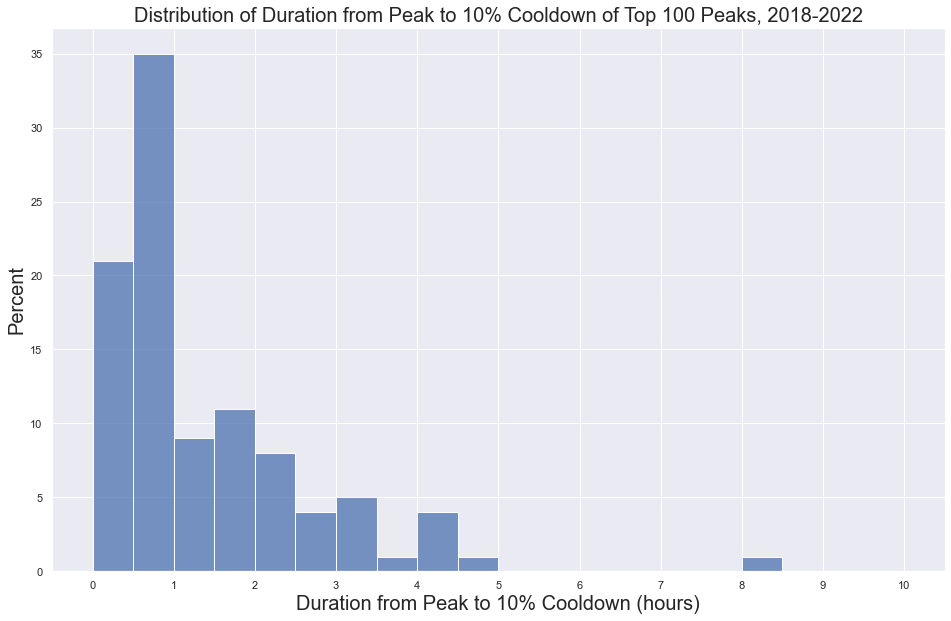

In [301]:
ax = sns.histplot(data=top_100_10_percent, x="duration", stat="percent", binwidth=0.5, binrange=[0, 10]);
ax.set(xticks=range(0, 11))
ax.set(title="")
ax.set_ylabel("Percent", fontsize = 20)
ax.set_xlabel("Duration from Peak to 10% Cooldown (hours)", fontsize = 20)
ax.set_title("Distribution of Duration from Peak to 10% Cooldown of Top 100 Peaks, 2018-2022", fontsize=20)
ax;

In [302]:
top_100_20_percent = get_top_n_extreme_intervals(100, 20, waking_hours_only=True)
top_100_20_percent.sort_values("duration", ascending=False)

,peak_time,end_time,peak_MOER,duration
1974,2019-02-28 08:25:00-08:00,2019-02-28 16:10:00-08:00,1076.500000,7.750000
4662,2021-02-09 15:40:00-08:00,2021-02-09 23:10:00-08:00,1185.833333,7.500000
4663,2021-02-09 15:55:00-08:00,2021-02-09 23:10:00-08:00,1190.500000,7.250000
4447,2020-12-30 16:05:00-08:00,2020-12-30 22:55:00-08:00,1189.333333,6.833333
6477,2022-03-19 08:00:00-07:00,2022-03-19 14:40:00-07:00,1111.500000,6.666667
...,...,...,...,...
1591,2018-12-11 09:35:00-08:00,2018-12-11 09:45:00-08:00,1088.500000,0.166667
301,2018-02-21 16:00:00-08:00,2018-02-21 16:10:00-08:00,1091.333333,0.166667
6068,2021-12-24 15:05:00-08:00,2021-12-24 15:15:00-08:00,1092.166667,0.166667
6057,2021-12-18 15:00:00-08:00,2021-12-18 15:10:00-08:00,1099.833333,0.166667


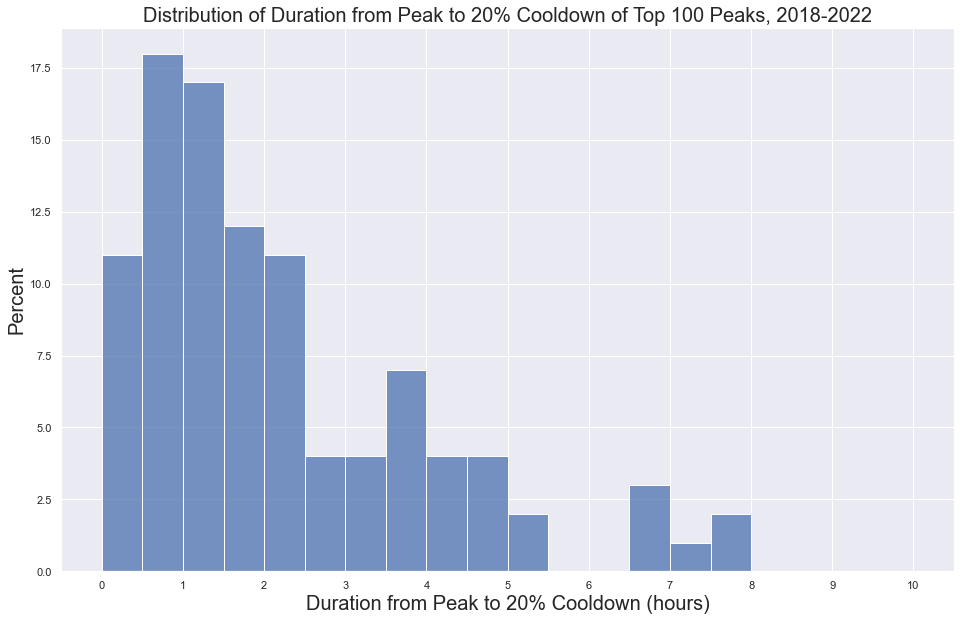

In [304]:
ax = sns.histplot(data=top_100_20_percent, x="duration", stat="percent", binwidth=0.5, binrange=[0, 10]);
ax.set(xticks=range(0, 11))
ax.set(title="")
ax.set_ylabel("Percent", fontsize = 20)
ax.set_xlabel("Duration from Peak to 20% Cooldown (hours)", fontsize = 20)
ax.set_title("Distribution of Duration from Peak to 20% Cooldown of Top 100 Peaks, 2018-2022", fontsize=20)
ax;

In [305]:
top_100_30_percent = get_top_n_extreme_intervals(100, 30, waking_hours_only=True)
top_100_30_percent.sort_values("duration", ascending=False)

,peak_time,end_time,peak_MOER,duration
2473,2019-02-28 08:25:00-08:00,2019-02-28 16:15:00-08:00,1076.500000,7.833333
4019,2020-01-16 16:25:00-08:00,2020-01-16 23:50:00-08:00,1067.333333,7.416667
4020,2020-01-16 16:45:00-08:00,2020-01-16 23:50:00-08:00,1073.000000,7.083333
8136,2022-03-19 08:00:00-07:00,2022-03-19 14:45:00-07:00,1111.500000,6.750000
4332,2020-03-13 08:25:00-07:00,2020-03-13 14:35:00-07:00,1067.833333,6.166667
...,...,...,...,...
1259,2018-07-05 15:55:00-07:00,2018-07-05 16:10:00-07:00,1066.333333,0.250000
3455,2019-09-05 16:40:00-07:00,2019-09-05 16:50:00-07:00,1066.166667,0.166667
7626,2021-12-24 15:05:00-08:00,2021-12-24 15:15:00-08:00,1092.166667,0.166667
2098,2018-12-12 12:15:00-08:00,2018-12-12 12:25:00-08:00,1068.666667,0.166667


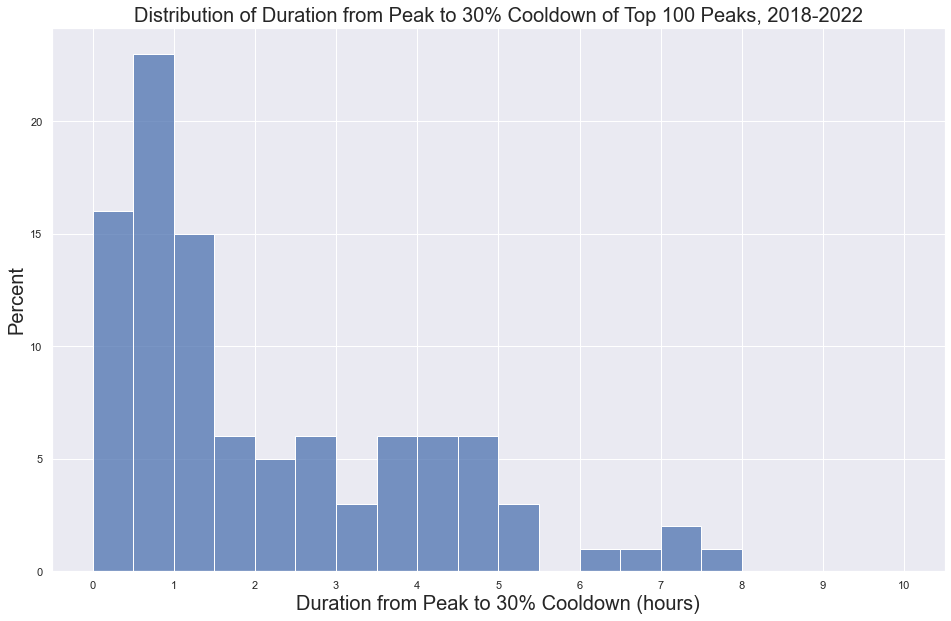

In [306]:
ax = sns.histplot(data=top_100_30_percent, x="duration", stat="percent", binwidth=0.5, binrange=[0, 10]);
ax.set(xticks=range(0, 11))
ax.set(title="")
ax.set_ylabel("Percent", fontsize = 20)
ax.set_xlabel("Duration from Peak to 30% Cooldown (hours)", fontsize = 20)
ax.set_title("Distribution of Duration from Peak to 30% Cooldown of Top 100 Peaks, 2018-2022", fontsize=20)
ax;

In [307]:
top_100_50_percent = get_top_n_extreme_intervals(100, 50, waking_hours_only=True)
top_100_50_percent.sort_values("duration", ascending=False)

,peak_time,end_time,peak_MOER,duration
2945,2020-01-16 16:25:00-08:00,2020-01-16 23:55:00-08:00,1067.333333,7.500000
2946,2020-01-16 16:45:00-08:00,2020-01-16 23:55:00-08:00,1073.000000,7.166667
6091,2022-03-19 08:00:00-07:00,2022-03-19 14:55:00-07:00,1111.500000,6.916667
3157,2020-03-13 08:25:00-07:00,2020-03-13 14:50:00-07:00,1067.833333,6.416667
211,2018-02-12 09:25:00-08:00,2018-02-12 15:00:00-08:00,1088.166667,5.583333
...,...,...,...,...
3082,2020-02-29 08:30:00-08:00,2020-02-29 08:55:00-08:00,1088.333333,0.416667
5853,2022-02-06 08:30:00-08:00,2022-02-06 08:55:00-08:00,1066.666667,0.416667
5955,2022-02-24 15:30:00-08:00,2022-02-24 15:50:00-08:00,1064.666667,0.333333
5665,2021-12-18 15:00:00-08:00,2021-12-18 15:20:00-08:00,1099.833333,0.333333


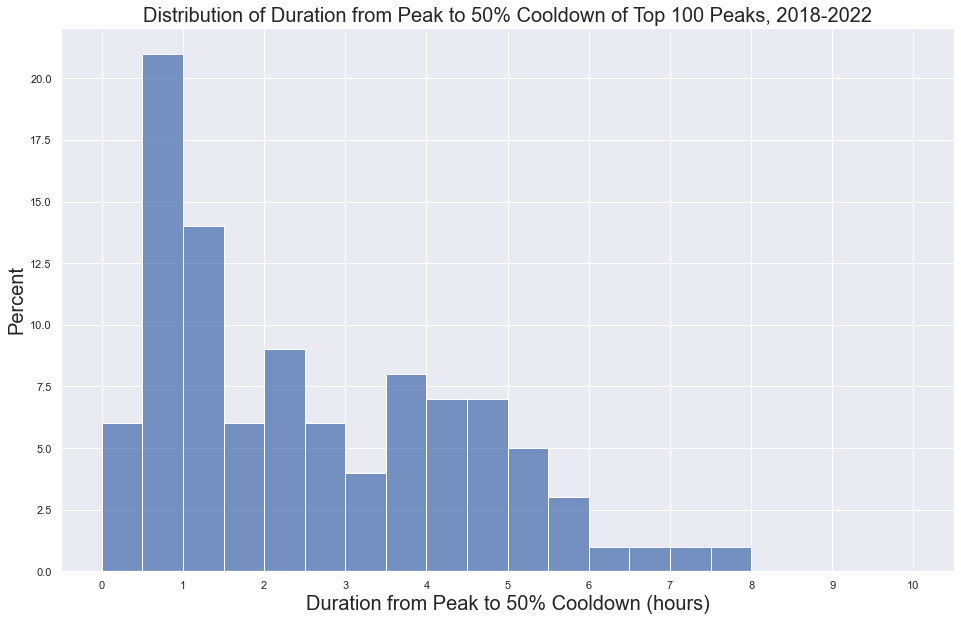

In [308]:
ax = sns.histplot(data=top_100_50_percent, x="duration", stat="percent", binwidth=0.5, binrange=[0, 10]);
ax.set(xticks=range(0, 11))
ax.set(title="")
ax.set_ylabel("Percent", fontsize = 20)
ax.set_xlabel("Duration from Peak to 50% Cooldown (hours)", fontsize = 20)
ax.set_title("Distribution of Duration from Peak to 50% Cooldown of Top 100 Peaks, 2018-2022", fontsize=20)
ax;